In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import os as os
from sklearn.impute import SimpleImputer #SFCrime외국인코드 보고 따온 것
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

In [0]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/SFdata/train.csv',parse_dates=['Dates'])
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/SFdata/test.csv',parse_dates=['Dates'],index_col='Id')

In [4]:
train

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607


In [5]:
test

,Dates,DayOfWeek,PdDistrict,Address,X,Y
Id,,,,,,
0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
...,...,...,...,...,...,...
884257,2003-01-01 00:01:00,Wednesday,MISSION,2600 Block of BRYANT ST,-122.408983,37.751987
884258,2003-01-01 00:01:00,Wednesday,NORTHERN,1900 Block of WASHINGTON ST,-122.425342,37.792681
884259,2003-01-01 00:01:00,Wednesday,INGLESIDE,5500 Block of MISSION ST,-122.445418,37.712075


In [0]:
train.drop_duplicates(inplace=True)
train.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
test.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp = SimpleImputer(strategy='mean')

for district in train['PdDistrict'].unique():
    train.loc[train['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(train.loc[train['PdDistrict'] == district, ['X', 'Y']])
    test.loc[test['PdDistrict'] == district, ['X', 'Y']] = imp.transform(test.loc[test['PdDistrict'] == district, ['X', 'Y']])

In [0]:
def feature_engineering(data):
    data['Date'] = pd.to_datetime(data['Dates'].dt.date)
    data['n_days'] = (data['Date'] - data['Date'].min()).apply(lambda x: x.days)
    data['Day'] = data['Dates'].dt.day
    data['DayOfWeek'] = data['Dates'].dt.weekday
    data['Month'] = data['Dates'].dt.month
    data['Year'] = data['Dates'].dt.year
    data['Hour'] = data['Dates'].dt.hour
    data['Minute'] = data['Dates'].dt.minute
    data['Block'] = data['Address'].str.contains('block', case=False)
    
    data.drop(columns=['Dates','Date','Address'], inplace=True)
        
    return data

In [0]:
train = feature_engineering(train)
train.drop(columns=['Descript','Resolution'], inplace=True)
test = feature_engineering(test)

In [0]:
#범주형 변수 인코딩
le1 = LabelEncoder()
train['PdDistrict'] = le1.fit_transform(train['PdDistrict'])
test['PdDistrict'] = le1.transform(test['PdDistrict'])

le2 = LabelEncoder()
train_x = train.drop(columns=['Category'])
train_y= le2.fit_transform(train['Category'])

In [11]:
train_x


,DayOfWeek,PdDistrict,X,Y,n_days,Day,Month,Year,Hour,Minute,Block
0,2,4,-122.425892,37.774599,4510,13,5,2015,23,53,False
1,2,4,-122.425892,37.774599,4510,13,5,2015,23,53,False
2,2,4,-122.424363,37.800414,4510,13,5,2015,23,33,False
3,2,4,-122.426995,37.800873,4510,13,5,2015,23,30,True
4,2,5,-122.438738,37.771541,4510,13,5,2015,23,30,True
...,...,...,...,...,...,...,...,...,...,...,...
878044,0,8,-122.459033,37.714056,0,6,1,2003,0,15,False
878045,0,2,-122.447364,37.731948,0,6,1,2003,0,1,True
878046,0,7,-122.403390,37.780266,0,6,1,2003,0,1,False
878047,0,7,-122.390531,37.780607,0,6,1,2003,0,1,False


In [12]:
train_y_d=pd.DataFrame(train_y)
train_y_d.apply(pd.value_counts)

,0
16,174320
21,125960
20,91915
1,76815
7,53919
36,53706
35,44581
37,42145
4,36600
32,31394


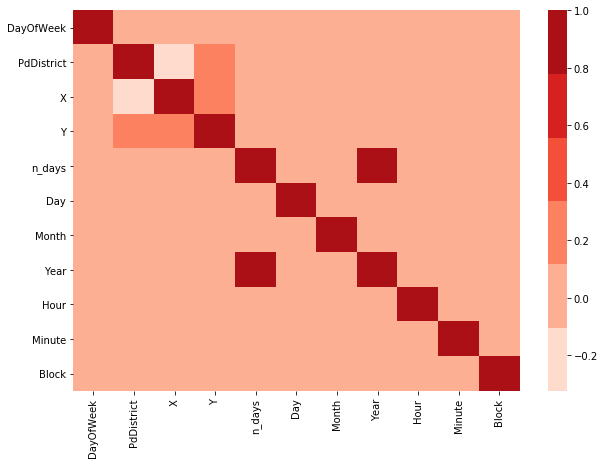

In [13]:
corr = train.corr()
cmap = sns.color_palette("Reds")
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr, cmap=cmap)

## n_days 변수와 year 변수 간 상관관계가 있음

In [14]:
import scipy as sp
from scipy.special import boxcox1p
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy.stats import uniform
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from imblearn.under_sampling import *
from imblearn.over_sampling import *
from imblearn.combine import *
from sklearn.impute import SimpleImputer

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [15]:
tl=TomekLinks() 
#Tomek Links는 언더샘플링에 대응하는 방식이므로, 반드시 imblearn.under_sampling 패키지가 임포트 되어있어야함
tl_train_x,tl_train_y = tl.fit_sample(train_x, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [16]:

tl_X_train=pd.DataFrame(tl_train_x)
tl_X_train.columns=['DayOfWeek', 'PdDistrict', 'X', 'Y', 'n_days',	'Day',	'Month',	'Year',	'Hour','Minute',	'Block']
tl_X_train

,DayOfWeek,PdDistrict,X,Y,n_days,Day,Month,Year,Hour,Minute,Block
0,2.0,4.0,-122.425892,37.774599,4510.0,13.0,5.0,2015.0,23.0,53.0,0.0
1,2.0,4.0,-122.425892,37.774599,4510.0,13.0,5.0,2015.0,23.0,53.0,0.0
2,2.0,4.0,-122.424363,37.800414,4510.0,13.0,5.0,2015.0,23.0,33.0,0.0
3,2.0,4.0,-122.426995,37.800873,4510.0,13.0,5.0,2015.0,23.0,30.0,1.0
4,2.0,5.0,-122.438738,37.771541,4510.0,13.0,5.0,2015.0,23.0,30.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
666905,0.0,6.0,-122.472985,37.782552,0.0,6.0,1.0,2003.0,0.0,31.0,0.0
666906,0.0,0.0,-122.389769,37.730564,0.0,6.0,1.0,2003.0,0.0,20.0,1.0
666907,0.0,0.0,-122.389769,37.730564,0.0,6.0,1.0,2003.0,0.0,20.0,1.0
666908,0.0,2.0,-122.447364,37.731948,0.0,6.0,1.0,2003.0,0.0,1.0,1.0


In [17]:
#언더샘플링 y데이터프레임
tl_y_d=pd.DataFrame(tl_train_y)
tl_y_d.apply(pd.value_counts)

,0
16,126681
21,100888
20,62545
1,60266
7,49113
36,41883
37,36255
35,29303
4,23397
32,21577


In [0]:
# Holdout
from sklearn.model_selection import train_test_split
tl_X_train, tl_X_valid, tl_y_train, tl_y_valid = train_test_split(tl_X_train, tl_train_y, test_size=0.30, random_state=None, stratify = tl_train_y)
# https://codedragon.tistory.com/7541
# https://roboreport.co.kr/%EA%B8%B0%EA%B3%84%ED%95%99%EC%8A%B5-%ED%9B%88%EB%A0%A8-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EA%B5%AC%EC%84%B1-%EB%B0%A9%EB%B2%95/
# random_state는 int, randomstate instance 또는 None 값을 사용
# 정수 값을 입력하면 숫자를 random하게 생성할때 사용되는 seed 숫자로 사용되며
# None을 입력하면 np.random에서 제공하는 random number generator가 사용됨
#참고 https://statkclee.github.io/model/model-python-xgboost-hyper.html

In [19]:
tl_X_valid = pd.DataFrame(tl_X_valid)
tl_X_valid.columns = ['DayOfWeek',	'PdDistrict',	'X',	'Y',	'n_days',	'Day',	'Month',	'Year',	'Hour','Minute',	'Block']
tl_X_valid

,DayOfWeek,PdDistrict,X,Y,n_days,Day,Month,Year,Hour,Minute,Block
460738,4.0,3.0,-122.435296,37.752080,1397.0,3.0,11.0,2006.0,20.0,0.0,1.0
412411,3.0,0.0,-122.390972,37.734015,1760.0,1.0,11.0,2007.0,14.0,0.0,0.0
443460,1.0,8.0,-122.505928,37.760422,1534.0,20.0,3.0,2007.0,20.0,45.0,0.0
136840,4.0,7.0,-122.411087,37.778163,3672.0,25.0,1.0,2013.0,16.0,0.0,1.0
546215,1.0,2.0,-122.426678,37.719732,792.0,8.0,3.0,2005.0,16.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
318584,5.0,0.0,-122.392779,37.735038,2420.0,22.0,8.0,2009.0,23.0,39.0,0.0
302415,4.0,5.0,-122.440104,37.773685,2531.0,11.0,12.0,2009.0,8.0,37.0,1.0
352068,2.0,9.0,-122.413238,37.782843,2193.0,7.0,1.0,2009.0,7.0,52.0,1.0
509786,6.0,0.0,-122.399129,37.714532,1035.0,6.0,11.0,2005.0,5.0,0.0,1.0


XGB 모델링

In [0]:
#https://statkclee.github.io/model/model-python-xgboost-hyper.html
%%time
xgb_c1 = XGBClassifier(n_estimators=100, n_jobs=-1, learning_rate=0.05,max_depth=5)
xgb_c1.fit(tl_X_train,tl_y_train, early_stopping_rounds=5,eval_metric='mlogloss',eval_set=[(tl_X_train, tl_y_train), (tl_X_valid, tl_y_valid)])

In [0]:
xgb_c1_pred = xgb_c1.predict_proba(test)

In [0]:
test_id = test.index
test_id = pd.DataFrame(test_id)

In [0]:
sample_submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/SFdata/sampleSubmission.csv')

In [0]:
submission = pd.DataFrame(data = xgb_c1_pred)
submission = pd.concat([test_id, submission], axis = 1)
submission.columns = sample_submission.columns
submission

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0.003142,0.138946,0.002042,0.006397,0.023985,0.004826,0.006921,0.042814,0.006017,0.002440,0.002172,0.002599,0.007763,0.019098,0.002066,0.008704,0.072048,0.005337,0.002255,0.050968,0.081718,0.135654,0.001959,0.002774,0.001959,0.036284,0.005636,0.023045,0.005532,0.002029,0.009725,0.002355,0.042145,0.001946,0.010123,0.056883,0.067667,0.072316,0.029710
1,1,0.003994,0.081483,0.001838,0.008429,0.004313,0.004288,0.007856,0.065073,0.005833,0.001820,0.001858,0.001847,0.002786,0.006966,0.004681,0.003230,0.026884,0.008635,0.001958,0.007786,0.042913,0.441951,0.001763,0.002039,0.001763,0.039758,0.001836,0.015923,0.003894,0.001828,0.008287,0.001799,0.027301,0.001751,0.003125,0.026368,0.022604,0.074856,0.028678
2,2,0.002626,0.127854,0.001859,0.002233,0.049608,0.004332,0.007507,0.027022,0.010696,0.002366,0.002240,0.002250,0.005964,0.016228,0.001899,0.007015,0.267975,0.002868,0.002030,0.015514,0.083962,0.088747,0.001778,0.023968,0.001768,0.031290,0.002456,0.018732,0.005637,0.001830,0.010412,0.002136,0.022800,0.001765,0.013969,0.056528,0.019804,0.039051,0.013283
3,3,0.006030,0.169149,0.002099,0.006978,0.027205,0.004852,0.010380,0.025954,0.007267,0.002443,0.002232,0.002671,0.008703,0.008386,0.002123,0.008535,0.104984,0.004006,0.002959,0.037837,0.093551,0.105207,0.002013,0.015792,0.002013,0.045140,0.005437,0.026753,0.007124,0.002087,0.009993,0.002420,0.040003,0.001999,0.008997,0.063428,0.053929,0.047717,0.021607
4,4,0.006030,0.169149,0.002099,0.006978,0.027205,0.004852,0.010380,0.025954,0.007267,0.002443,0.002232,0.002671,0.008703,0.008386,0.002123,0.008535,0.104984,0.004006,0.002959,0.037837,0.093551,0.105207,0.002013,0.015792,0.002013,0.045140,0.005437,0.026753,0.007124,0.002087,0.009993,0.002420,0.040003,0.001999,0.008997,0.063428,0.053929,0.047717,0.021607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884257,884257,0.002251,0.090244,0.006625,0.002089,0.020621,0.004296,0.002570,0.022308,0.002532,0.058638,0.001881,0.003020,0.084100,0.076583,0.001645,0.003948,0.074476,0.001933,0.002109,0.021246,0.063131,0.157092,0.001560,0.007579,0.001546,0.008791,0.003687,0.016478,0.036460,0.004182,0.004144,0.002026,0.043490,0.001549,0.006092,0.038453,0.094664,0.016567,0.009395
884258,884258,0.002071,0.057994,0.011693,0.001571,0.067096,0.013888,0.003103,0.011325,0.002505,0.046356,0.002001,0.001966,0.080948,0.086827,0.001532,0.003643,0.136827,0.001881,0.002745,0.014248,0.062333,0.114384,0.001435,0.008044,0.001422,0.007678,0.001982,0.014430,0.017251,0.004064,0.005623,0.001864,0.052281,0.001425,0.006642,0.035269,0.098594,0.010288,0.004769
884259,884259,0.003907,0.099172,0.006321,0.002009,0.028098,0.003494,0.002649,0.016192,0.002047,0.041909,0.002544,0.002882,0.081821,0.064780,0.001569,0.003877,0.070188,0.001951,0.002096,0.023639,0.053624,0.123123,0.001488,0.003095,0.001475,0.006920,0.008063,0.015717,0.045399,0.003989,0.003826,0.003623,0.050215,0.001478,0.005262,0.042200,0.142816,0.018441,0.008103
884260,884260,0.009719,0.074593,0.005842,0.001814,0.027959,0.007238,0.002266,0.016571,0.002022,0.038722,0.001659,0.002664,0.063113,0.059104,0.002086,0.003482,0.068980,0.002420,0.001749,0.021896,0.047760,0.257171,0.001375,0.002033,0.001364,0.006547,0.003717,0.014340,0.033555,0.003688,0.003533,0.001787,0.033839,0.001366,0.005052,0.036621,0.093036,0.030207,0.009111


In [32]:
submission.to_csv('/content/drive/My Drive/Colab Notebooks/SFdata/crime_xgb_submission.csv', index=False)

KeyboardInterrupt: ignored

In [0]:
sample_submission

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884257,884257,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
884258,884258,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
884259,884259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
884260,884260,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


LGBM (Light GBM)
LGBM의 장점: 속도가 빠름
다룰 때 팁: 데이터가 작으면 Depth를 줄여주어야 함


In [20]:
tl_train_x=pd.DataFrame(tl_train_x)
tl_train_x.columns=['DayOfWeek',	'PdDistrict',	'X',	'Y',	'n_days',	'Day',	'Month',	'Year',	'Hour','Minute',	'Block']
tl_train_x

,DayOfWeek,PdDistrict,X,Y,n_days,Day,Month,Year,Hour,Minute,Block
0,2.0,4.0,-122.425892,37.774599,4510.0,13.0,5.0,2015.0,23.0,53.0,0.0
1,2.0,4.0,-122.425892,37.774599,4510.0,13.0,5.0,2015.0,23.0,53.0,0.0
2,2.0,4.0,-122.424363,37.800414,4510.0,13.0,5.0,2015.0,23.0,33.0,0.0
3,2.0,4.0,-122.426995,37.800873,4510.0,13.0,5.0,2015.0,23.0,30.0,1.0
4,2.0,5.0,-122.438738,37.771541,4510.0,13.0,5.0,2015.0,23.0,30.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
666905,0.0,6.0,-122.472985,37.782552,0.0,6.0,1.0,2003.0,0.0,31.0,0.0
666906,0.0,0.0,-122.389769,37.730564,0.0,6.0,1.0,2003.0,0.0,20.0,1.0
666907,0.0,0.0,-122.389769,37.730564,0.0,6.0,1.0,2003.0,0.0,20.0,1.0
666908,0.0,2.0,-122.447364,37.731948,0.0,6.0,1.0,2003.0,0.0,1.0,1.0


In [0]:
train_set = lgb.Dataset(
    tl_X_train, label=tl_y_train, categorical_feature=['PdDistrict'], free_raw_data=False)
valid_set = lgb.Dataset(tl_X_valid, label=tl_y_valid)

In [0]:
params = {'learning_rate': 0.1,
          'num_boost_round' : 1000,
          'max_depth':16,
          'boosting':'gbdt',
          'objective':'multiclass',
          'num_class':39,
          'max_delta_step':0.8,
          'min_data_in_leaf': 20,
          'max_bin': 400,
          'num_leaves': 30,
          'early_stopping_rounds':10
         }

In [25]:
%%time
bst = lgb.train(params, train_set, 1000 ,valid_sets=valid_set)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PdDistrict']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden

[1]	valid_0's multi_logloss: 2.6713
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_logloss: 2.64744
[3]	valid_0's multi_logloss: 2.62555
[4]	valid_0's multi_logloss: 2.60534
[5]	valid_0's multi_logloss: 2.5867
[6]	valid_0's multi_logloss: 2.56942
[7]	valid_0's multi_logloss: 2.55362
[8]	valid_0's multi_logloss: 2.53915
[9]	valid_0's multi_logloss: 2.52555
[10]	valid_0's multi_logloss: 2.51291
[11]	valid_0's multi_logloss: 2.50149
[12]	valid_0's multi_logloss: 2.49046
[13]	valid_0's multi_logloss: 2.48026
[14]	valid_0's multi_logloss: 2.47079
[15]	valid_0's multi_logloss: 2.46177
[16]	valid_0's multi_logloss: 2.45351
[17]	valid_0's multi_logloss: 2.44576
[18]	valid_0's multi_logloss: 2.43857
[19]	valid_0's multi_logloss: 2.43184
[20]	valid_0's multi_logloss: 2.42542
[21]	valid_0's multi_logloss: 2.41928
[22]	valid_0's multi_logloss: 2.41341
[23]	valid_0's multi_logloss: 2.40801
[24]	valid_0's multi_logloss: 2.40282
[25]	valid_0's multi_logloss: 2.39788

In [0]:
predictions = bst.predict(test)

In [0]:
test_id=test.index
test_id=pd.DataFrame(test_id)

In [34]:
submission=pd.DataFrame(data=predictions)
submission=pd.concat([test_id,submission],axis=1)
submission.columns=sample_submission.columns
submission

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0.000737,0.195549,3.711987e-09,3.934440e-06,0.116099,0.000061,0.000393,0.018012,0.004222,0.000003,5.972410e-07,0.000148,0.000643,0.000510,1.177197e-09,0.000219,0.073862,0.000496,0.000009,0.129632,0.063142,0.083826,2.707393e-10,0.000045,6.350059e-06,0.003540,3.387020e-05,0.004836,0.000568,1.145176e-09,0.013980,1.051523e-06,0.028400,4.209623e-11,0.004438,0.054604,0.124234,0.040756,0.036990
1,1,0.001363,0.074937,2.928323e-09,3.049500e-05,0.001802,0.000060,0.008524,0.058491,0.003509,0.000006,4.643349e-07,0.000004,0.000308,0.003225,5.602171e-09,0.000522,0.009370,0.002195,0.000005,0.003832,0.055119,0.579270,1.584718e-09,0.000037,5.402331e-06,0.006008,3.427723e-05,0.002707,0.000343,3.005158e-10,0.014331,4.375578e-08,0.023532,2.600826e-11,0.000568,0.016063,0.018117,0.077181,0.038501
2,2,0.000563,0.261087,2.122954e-08,4.398454e-06,0.065063,0.000233,0.000192,0.019648,0.003138,0.000003,7.334815e-08,0.000001,0.001126,0.011304,2.371798e-10,0.012519,0.202272,0.000140,0.000005,0.005545,0.068420,0.094610,8.434525e-10,0.001088,4.274769e-06,0.020623,3.960477e-05,0.004170,0.014263,6.026864e-09,0.005256,6.685684e-07,0.041262,3.664490e-10,0.014522,0.056824,0.046608,0.030069,0.019395
3,3,0.000646,0.201390,1.346584e-07,3.185474e-05,0.016277,0.000132,0.000569,0.013080,0.007407,0.000004,1.175235e-06,0.000044,0.000956,0.006244,1.763136e-09,0.006629,0.093374,0.019926,0.000005,0.035305,0.090638,0.060230,9.098022e-10,0.001019,7.026767e-06,0.014543,4.175044e-04,0.009370,0.003443,4.759114e-09,0.003439,1.070646e-05,0.023026,8.351661e-10,0.010762,0.065353,0.123750,0.021298,0.170673
4,4,0.000646,0.201390,1.346584e-07,3.185474e-05,0.016277,0.000132,0.000569,0.013080,0.007407,0.000004,1.175235e-06,0.000044,0.000956,0.006244,1.763136e-09,0.006629,0.093374,0.019926,0.000005,0.035305,0.090638,0.060230,9.098022e-10,0.001019,7.026767e-06,0.014543,4.175044e-04,0.009370,0.003443,4.759114e-09,0.003439,1.070646e-05,0.023026,8.351661e-10,0.010762,0.065353,0.123750,0.021298,0.170673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884257,884257,0.002032,0.089163,1.272103e-03,1.329428e-05,0.028792,0.000681,0.001481,0.025921,0.000976,0.003069,3.826888e-07,0.000047,0.112716,0.035856,6.440155e-09,0.000924,0.073188,0.001525,0.000064,0.020333,0.075091,0.253624,3.816895e-10,0.004938,1.159644e-06,0.004176,1.440315e-04,0.011819,0.063556,1.261612e-06,0.008237,2.127178e-04,0.043109,1.541364e-11,0.017819,0.061012,0.039365,0.012357,0.006485
884258,884258,0.000209,0.038153,6.331589e-04,5.113810e-07,0.037306,0.000972,0.000241,0.006061,0.000417,0.007418,6.421256e-08,0.000009,0.237784,0.033543,1.117704e-09,0.001212,0.125416,0.000077,0.000392,0.011057,0.075725,0.200920,2.167135e-10,0.000411,1.933507e-06,0.003736,3.029260e-07,0.001529,0.025809,5.091103e-09,0.003799,1.818438e-05,0.051674,3.133540e-11,0.002383,0.073091,0.056579,0.002360,0.001065
884259,884259,0.000372,0.173953,4.651249e-03,2.470088e-06,0.012631,0.000300,0.000005,0.012193,0.000112,0.004014,2.837413e-05,0.000016,0.113304,0.028832,6.507973e-09,0.000281,0.053542,0.000059,0.000039,0.006886,0.048065,0.168845,1.851902e-10,0.001314,6.711092e-07,0.002515,4.478302e-05,0.006092,0.152105,6.457902e-08,0.001512,8.977948e-04,0.047452,2.202500e-10,0.000766,0.017992,0.131198,0.006951,0.003028
884260,884260,0.000819,0.072926,1.673711e-05,7.366431e-06,0.031968,0.003681,0.000827,0.020176,0.000354,0.000347,7.117102e-07,0.

In [0]:
submission.to_csv('/content/drive/My Drive/Colab Notebooks/SFdata/lgb_bayes2_sample_submission.csv', index=False)
### num_boost_rounds = 1000, early_stopping :540 , Score : 2.25177